In [1]:
from IPython.display import display
import sys
import numpy as np
import pandas as pd
import os
from ebmdatalab import bq
import datetime
import plotly.express as px
import plotly.io as pio
from IPython.display import Markdown
import warnings
import requests
warnings.filterwarnings('ignore')
pio.templates.default = "plotly_white"
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
import scipy.stats as stats
register_matplotlib_converters()
from statsforecast import StatsForecast

from statsforecast.models import ARIMA
from time import time
import seaborn as sns
sns.set(style="whitegrid")
#from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.models import AutoETS
from statsforecast.arima import arima_string
import warnings
warnings.filterwarnings('ignore')
import time


In [2]:
%run forecasting.py

# Prototyping ARIMA forecasting for primary care prescribing data

Some stuff here about terrible forecasting.

## Set test modelling parameters before starting

In [236]:
start_training = '2020-04-01'
end_training = '2023-06-01'
start_forecast = '2023-07-01'
end_forecast = '2024-03-01'

#Calculate start of financial year
#current_fy =(financial_year_start(start_forecast)
current_fy = financial_year_start(start_forecast)
# Define the top x% you want to identify
top_x_percent = 95 
multiplier_limit = 50

In [202]:
print(current_fy)

2023-04-01 00:00:00


### Step 1: Get price data

#### Step 1a: obtain Drug Tariff and price concession data

In [203]:
# define SQL for getting dt data from BigQuery
# this gets dt data, and substitutes price concession data where it exists for a VMPP and date.  It only gets data between the start data and end forecast variables defined above.

sql = f""" 
SELECT
  dt.date AS month,
  dt.vmpp AS vmpp,
  vmpp.bnf_code AS bnf_code,
  dt.price_pence AS price_pence,
  pc.price_pence AS pc_price_pence,
  dt.tariff_category AS dt_category,
  CASE
      WHEN vmpp.qty_uom = 3317411000001100 THEN 1 
      WHEN vmpp.qty_uom = 258770004 THEN (vmpp.qtyval * 1000)
      ELSE vmpp.qtyval END AS qtyval
FROM
  dmd.tariffprice AS dt
INNER JOIN
  dmd.vmpp AS vmpp
ON
  dt.vmpp = vmpp.id
LEFT OUTER JOIN
  dmd.ncsoconcession AS pc
ON
  dt.vmpp = pc.vmpp
  AND dt.date = pc.date
WHERE dt.date BETWEEN '{start_training}' AND '{end_forecast}'
"""
exportfile = os.path.join("..","data","dt_price_df.csv") # defines name for cache file
dt_raw_df = bq.cached_read(sql, csv_path=exportfile, use_cache=False) # uses BQ if changed, otherwise csv cache file
dt_raw_df['price_per_unit'] = dt_raw_df['price_pence']/dt_raw_df['qtyval'] # create price per unit column for dt data
dt_raw_df['pc_price_per_unit'] = dt_raw_df['pc_price_pence']/dt_raw_df['qtyval'] # create price per unit column for dt data
dt_raw_df['month'] = pd.to_datetime(dt_raw_df['month']) # ensure month data is datetime format
dt_raw_df['price_per_unit'] = dt_raw_df['price_per_unit'].astype(float) # ensure ppu is in float
dt_raw_df['pc_price_per_unit'] = dt_raw_df['pc_price_per_unit'].astype(float) # ensure ppu is in float

Downloading: 100%|█████████████████████████████████████████████████████████████|


In [204]:
dt_price_df = rank_and_filter_prices(dt_raw_df) #use function create ranking of price per unit for each BNF code (as possibly multiple VMPPs per BNF code), and create filtered df containing only the top ranked one

In [205]:
dt_price_df.head()

,month,bnf_code,dt_category,price_per_unit,pc_price_per_unit
0,2020-04-01,190400000AAAIAI,1,25.4,NaN
1,2020-05-01,190400000AAAIAI,1,25.4,NaN
2,2020-06-01,190400000AAAIAI,1,25.4,NaN
3,2020-07-01,190400000AAAIAI,1,25.4,NaN
4,2020-08-01,190400000AAAIAI,1,25.4,NaN


#### Step 1b: obtain other drug costs

In [206]:
# define SQL for getting dt data from BigQuery
# this gets dm+d data, where there is an NHS indicative price listed
sql = """
SELECT
  ampp.id AS ampp,
  ampp.bnf_code,
  priceinfo_price,
  priceinfo_pricedt,
  priceinfo_price_prev,
    CASE 
        WHEN vmpp.qty_uom = 3317411000001100 THEN 1 
        WHEN vmpp.qty_uom = 258770004 THEN (vmpp.qtyval * 1000)
        ELSE qtyval END AS qtyval
FROM
  `ebmdatalab.dmd.ampp_full` AS ampp
INNER JOIN
  dmd.vmpp AS vmpp
ON
  ampp.vmpp = vmpp.id
WHERE
  priceinfo_price_basis = 'NHS Indicative Price'
"""
exportfile = os.path.join("..","data","dmd_raw_df.csv") # defines name for cache file
dmd_raw_df = bq.cached_read(sql, csv_path=exportfile, use_cache=False) # uses BQ if changed, otherwise csv cache file
dmd_raw_df['priceinfo_pricedt'] = pd.to_datetime(dmd_raw_df['priceinfo_pricedt']) # convert priceinfo_pricedt to datetime
dmd_raw_df['qtyval'] = dmd_raw_df['qtyval'].astype(float)

Downloading: 100%|█████████████████████████████████████████████████████████████|


In [207]:
##SORT DATE VARIABLES###

dmd_price_df = process_dmd_data(dmd_raw_df, start_forecast, end_forecast) #use function to process dm+d data into a df with month and bnf_code data, only having one row for each bnf_code and month

In [208]:
dmd_price_df.head()

,month,bnf_code,price_per_unit
33088,2023-07-01,0101010F0BCAAAU,307.333333
118081,2023-08-01,0101010F0BCAAAU,307.333333
203074,2023-09-01,0101010F0BCAAAU,307.333333
288067,2023-10-01,0101010F0BCAAAU,307.333333
373060,2023-11-01,0101010F0BCAAAU,307.333333


#### Step 1c: merge data into single dataframe

In [209]:
full_price_df = merge_and_update_prices(dmd_price_df, dt_price_df) # use function to merge dm+d codes (which are not already included in dt) into dt df to create single list of prices
nadp_df = pd.read_csv(os.path.join("..","data","nadp_data.csv")) #open NADP file (for <2024-04-01 usage)
nadp_df['month'] = pd.to_datetime(nadp_df['month'])
nadp_adjuster(full_price_df, nadp_df)
#remove all zero costs
full_price_df = full_price_df[full_price_df['price_per_unit'] != 0]

In [210]:
nadp_df.dtypes

nadp    float64
dtype: object

In [211]:
full_price_df.head()

,month,bnf_code,dt_category,price_per_unit,pc_price_per_unit
0,2020-04-01,190400000AAAIAI,1,23.61184,NaN
1,2020-05-01,190400000AAAIAI,1,23.60676,NaN
2,2020-06-01,190400000AAAIAI,1,23.59660,NaN
3,2020-07-01,190400000AAAIAI,1,23.59406,NaN
4,2020-08-01,190400000AAAIAI,1,23.61692,NaN


### Step 2: get prescribing data

In [212]:
sql = f"""
SELECT DATE(month) AS month,
       bnf_name,
       bnf_code,
       SUM(quantity) AS quantity,
       SUM(items) AS items,
       SUM(actual_cost) AS actual_cost
FROM   hscic.normalised_prescribing 
WHERE  month BETWEEN '{start_training}' AND '{end_forecast}'
GROUP BY month,
          bnf_code,
          bnf_name 
"""

exportfile = os.path.join("..","data","rx_df.csv") #defines name for cache file
rx_df = bq.cached_read(sql, csv_path=exportfile, use_cache=True) #uses BQ if changed, otherwise csv cache file
rx_df['month'] = pd.to_datetime(rx_df['month']) #ensure dates are in datetimeformat

In [213]:
rx_df.head()
# create a filtered rx_df to find anomalous PPUs - filter to current financial year
current_rx_df = rx_df[(rx_df['month'] >= current_fy) & (rx_df['month'] <= end_training)]



current_rx_ppu_df  = current_rx_df.groupby(['bnf_code', 'bnf_name'], as_index=False).apply(lambda x: pd.Series({
    'avg_ppu': x['actual_cost'].sum() / x['quantity'].sum()
}))

In [214]:
# find median ppu from "price list"
median_price_df = full_price_df.groupby(['bnf_code'], as_index=False)[['price_per_unit','pc_price_per_unit']].median()

In [215]:
current_rx_ppu_df.head()

,bnf_code,bnf_name,avg_ppu
0,0101010F0AAAUAU,Magnesium carbonate heavy 500mg capsules,2.774624
1,0101010F0AABEBE,Magnesium carbonate 500mg capsules,2.507581
2,0101010F0BCAAAU,Magnesite 500mg capsules,2.894134
3,0101010G0AAABAB,Co-magaldrox 195mg/220mg/5ml oral suspension s...,0.005652
4,0101010G0AAAGAG,Co-magaldrox 200mg/175mg/5ml oral suspension s...,0.014482


In [216]:
median_price_df.head()

,bnf_code,price_per_unit,pc_price_per_unit
0,0101010C0AAAAAA,10.619537,NaN
1,0101010F0BCAAAU,288.770400,NaN
2,0101010F0BDABBE,249.996240,NaN
3,0101010F0BEAAAU,249.996240,NaN
4,0101010F0BFAAAU,250.497360,NaN


In [239]:
merged_ppu_df = pd.merge(current_rx_ppu_df, median_price_df, on='bnf_code', how='inner')
#change avg_ppg to pence
merged_ppu_df['avg_ppu'] = merged_ppu_df['avg_ppu'] *100
merged_ppu_df['multiplier'] = merged_ppu_df['avg_ppu']/merged_ppu_df['price_per_unit']
merged_ppu_df = merged_ppu_df.sort_values(by='multiplier', ascending=True)
merged_ppu_df = merged_ppu_df[(merged_ppu_df['multiplier'] >= multiplier_limit) | (merged_ppu_df['multiplier'] <= 1/multiplier_limit)]

In [240]:
merged_ppu_df.head(50)

,bnf_code,bnf_name,avg_ppu,price_per_unit,pc_price_per_unit,multiplier
8051,1002020Y0BBABAB,Sativex oromucosal spray,104.767475,28188.00000,NaN,0.003717
8050,1002020Y0AAABAB,Dronabinol 2.7mg / Cannabidiol 2.5mg/dose orom...,105.011852,28044.00000,NaN,0.003745
5340,0607020B0AAAAAA,Buserelin 150micrograms/dose nasal spray,58.952827,9830.35680,NaN,0.005997
1690,0302000K0BJAAAM,WockAIR 160micrograms/dose / 4.5micrograms/dos...,14.917098,1785.24000,NaN,0.008356
13412,21190000004,Caphosol mouthrinse,105.489311,12280.57200,NaN,0.008590
2254,0402010J0AAAAAA,Haloperidol 500microgram capsules,251.921748,3.65564,NaN,68.913172


### Step 3: work out the top X percent of items and cost for BNF codes

In [219]:
topx_rx_df, non_topx_rx_df, top_bnf_codes = filter_top_bnf_codes(rx_df, top_x_percent) # uses function to create separate dataframes for presentations with item or cost either in or not in top_x_percent

Number of BNF codes in top 95% items or spend: 4317


### Step 4: create dataframe for use with ARIMA forecasting tool

In [220]:
# create df for use with statsforecast, having only neccesary columns and named correctly
arima_df = topx_rx_df[['month', 'bnf_code', 'quantity']].copy()

# Rename columns to fit statsforecast
arima_df.rename(columns={
    'month': 'ds',
    'bnf_code': 'unique_id',
    'quantity': 'y'
}, inplace=True)

### Step 5: Create dataframe and variables for testing at various points in financial year

In [221]:
# set variables for test modelling
latest_data = pd.to_datetime(start_forecast) # test month for last data available - allows us to model throughout the year
latest_pricing_data = pd.to_datetime(latest_data  + pd.DateOffset(months=2)) # assume that pricing data is usually two months ahead of prescribing data for testing purposes

# create test df for testing fit models CHANGED
filtered_arima_df = arima_df[(arima_df['ds'] >= current_fy) & (arima_df['ds'] <= end_training)].sort_values(by=['ds','unique_id']) # creates testing model of prescribing data with modelling for various points in the year

training_arima_df = fill_missing_combinations(filtered_arima_df, current_fy, end_training) #ensure really seasonal data (e.g. flu vaccines) have 0 in other months **CHANGED TO DO PREDICTION*
#THIS HAS CHANGED AS WELL
horizon = 1 + (pd.to_datetime(end_forecast).year - pd.to_datetime(current_fy).year) * 12 + (pd.to_datetime(end_forecast).month - pd.to_datetime(current_fy).month) # calculates the number of months needed in the prediction, depending on number of months of in year data avaialble


In [222]:
print(start_training)
print(end_training)
print(horizon)

2020-04-01
2023-06-01
12


### Step 6: Create ARIMA forecasting model and undertake forecasting for top x BNF codes

In [223]:
# create statsforecast model
season_length = 12 # Monthly data 
models = [AutoARIMA(season_length=season_length)] # set AutoARIMA as model
#models = [AutoETS(season_length=season_length)] # set AutoARIMA as model
sf = StatsForecast(df=training_arima_df,
                   models=models,
                   freq='MS', #frequency start of month
                   n_jobs=-1) # use all processors

forecast_rx_df = sf.forecast(horizon, level=[95])  #, fitted=True
forecast_rx_df = forecast_rx_df.reset_index();


In [224]:
full_forecast_rx_df = pd.merge(topx_rx_df, forecast_rx_df, left_on=['month', 'bnf_code'], right_on=['ds','unique_id'], how='outer').sort_values(by=['month'])

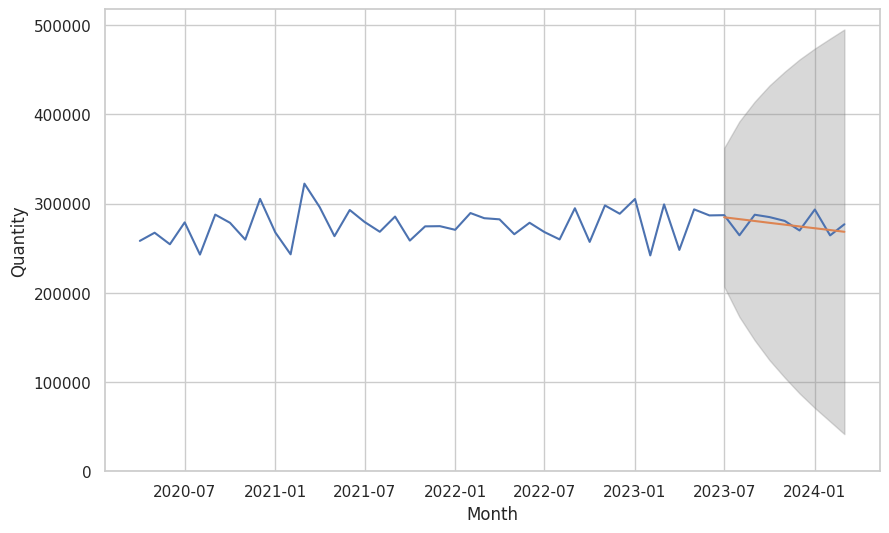

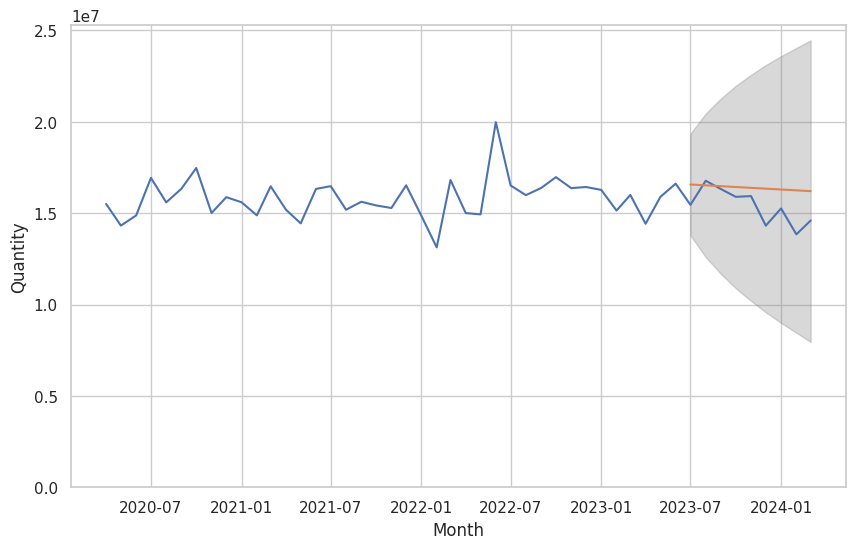

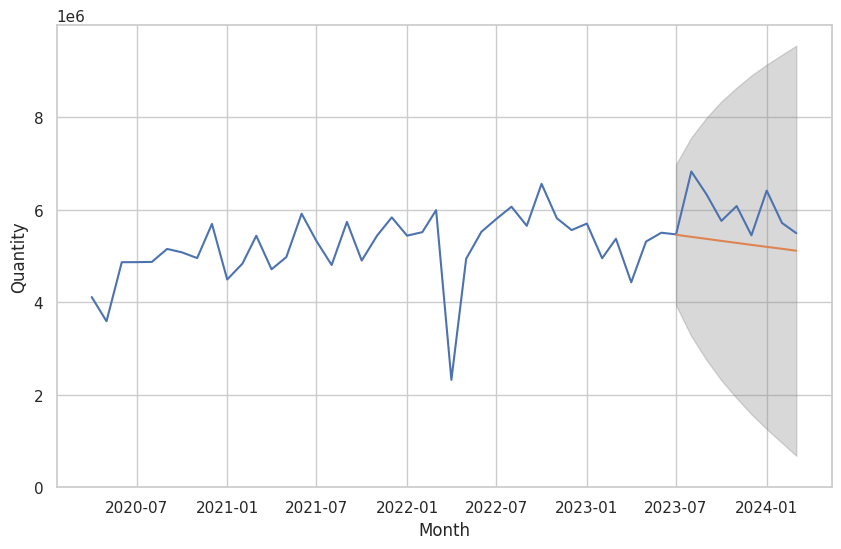

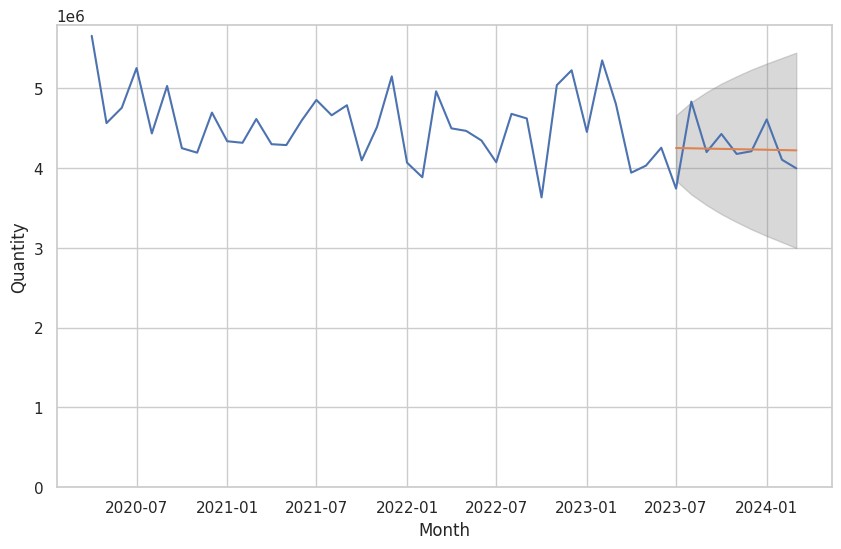

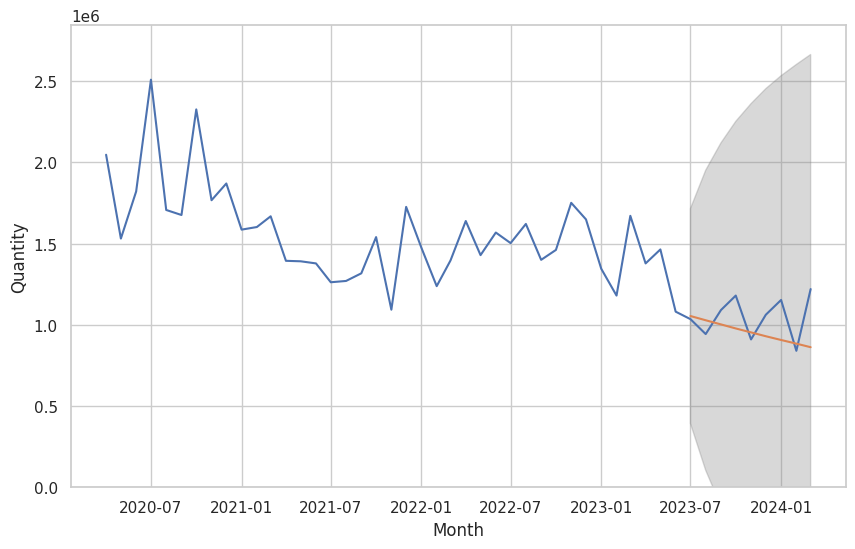

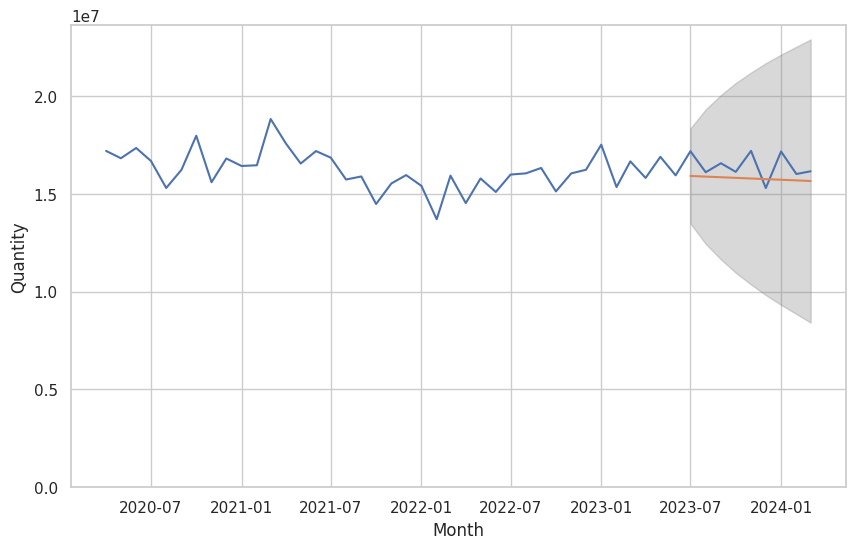

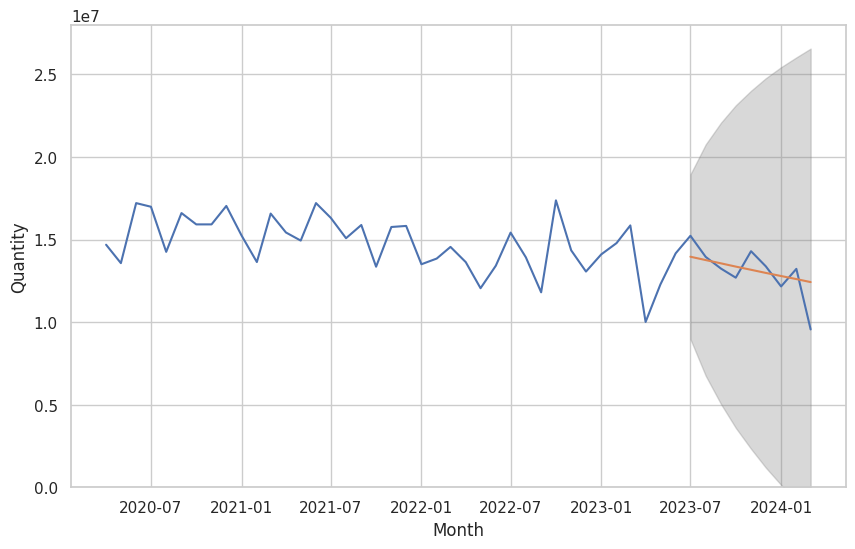

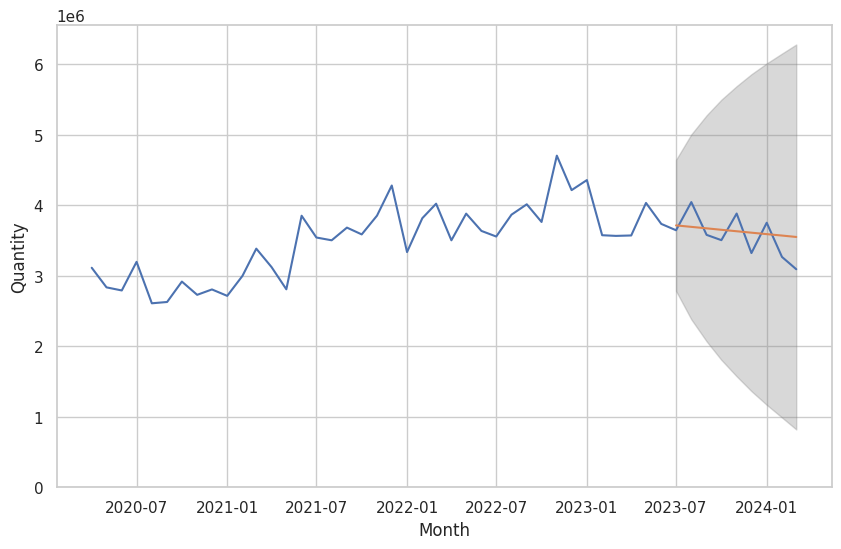

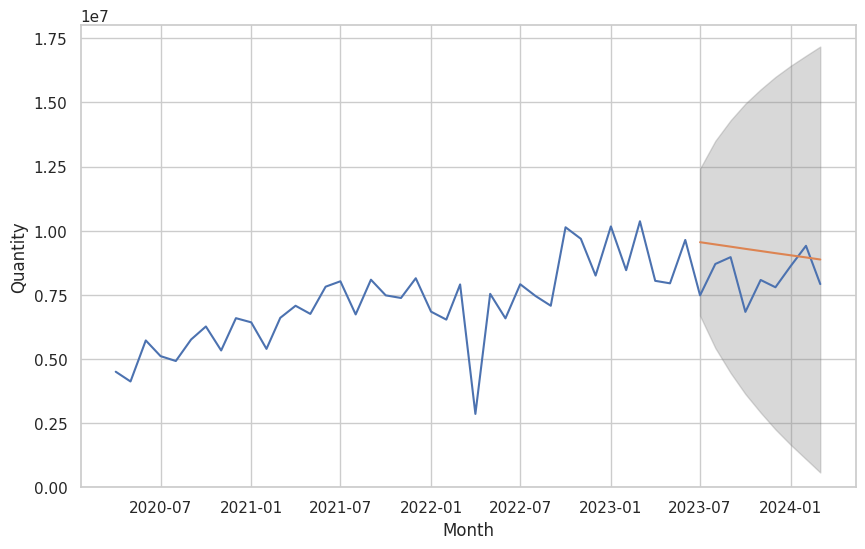

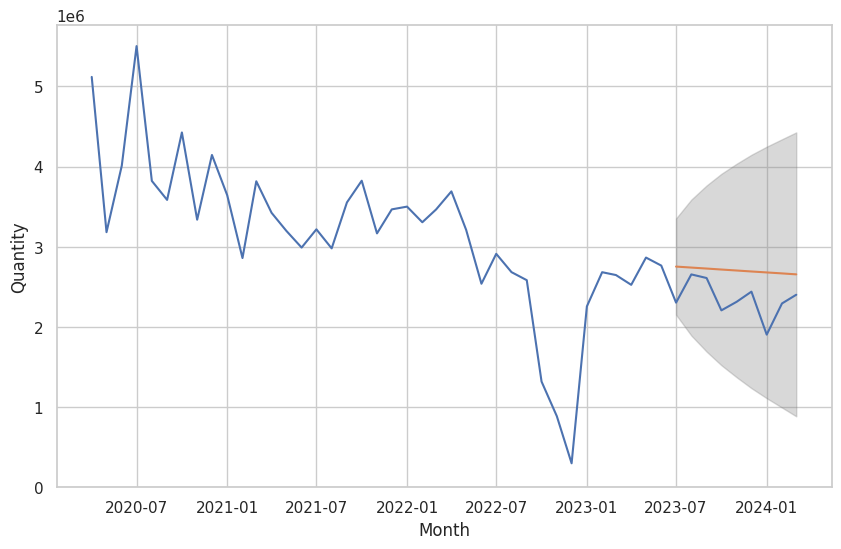

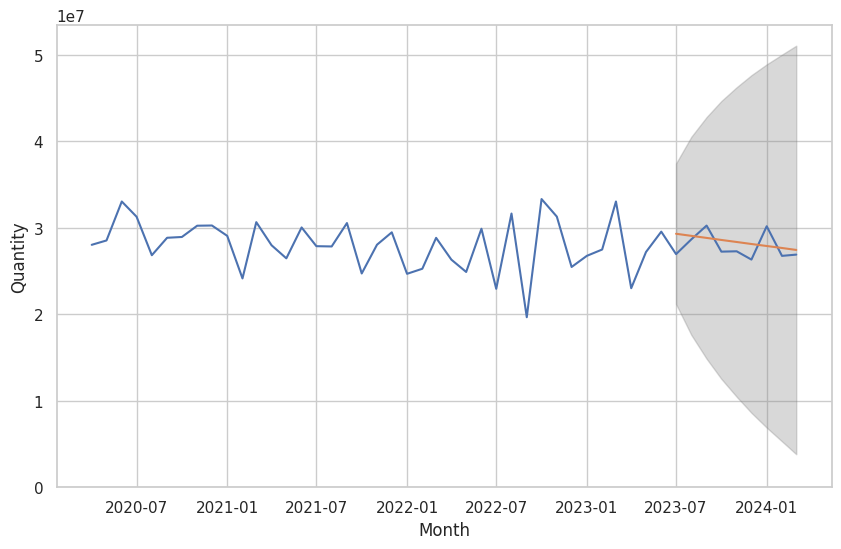

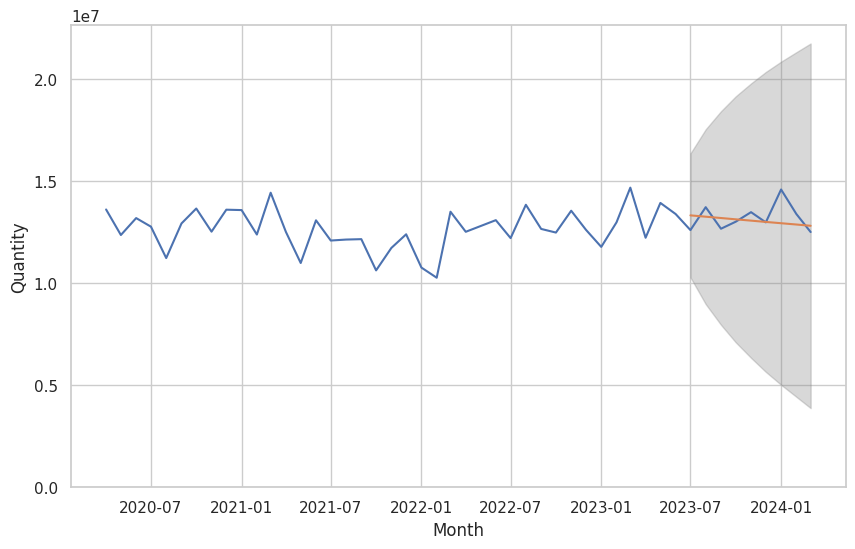

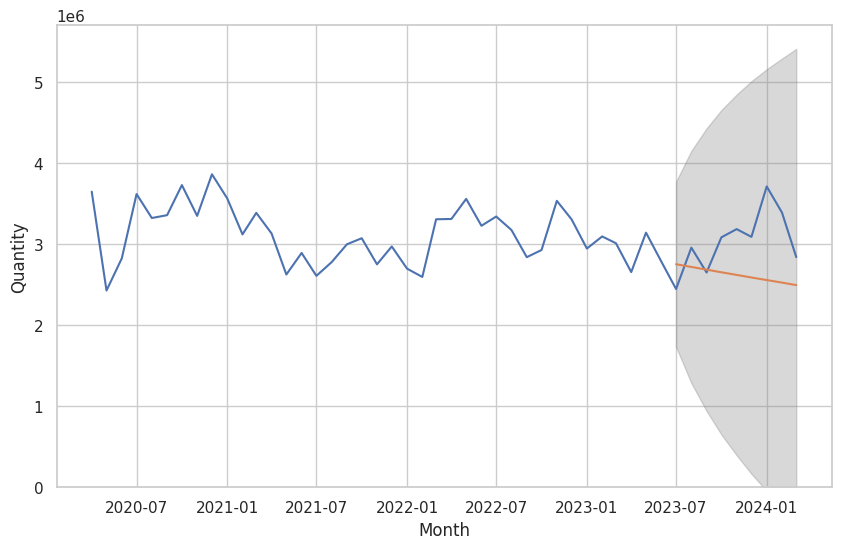

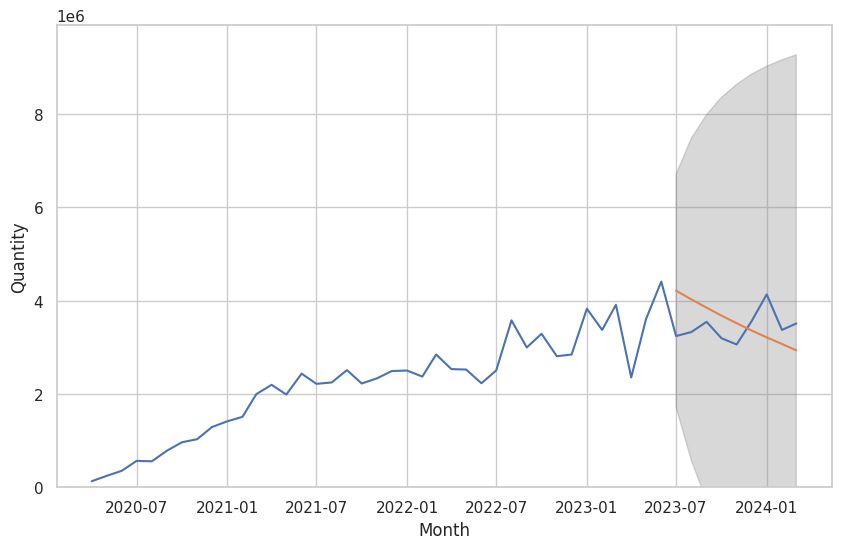

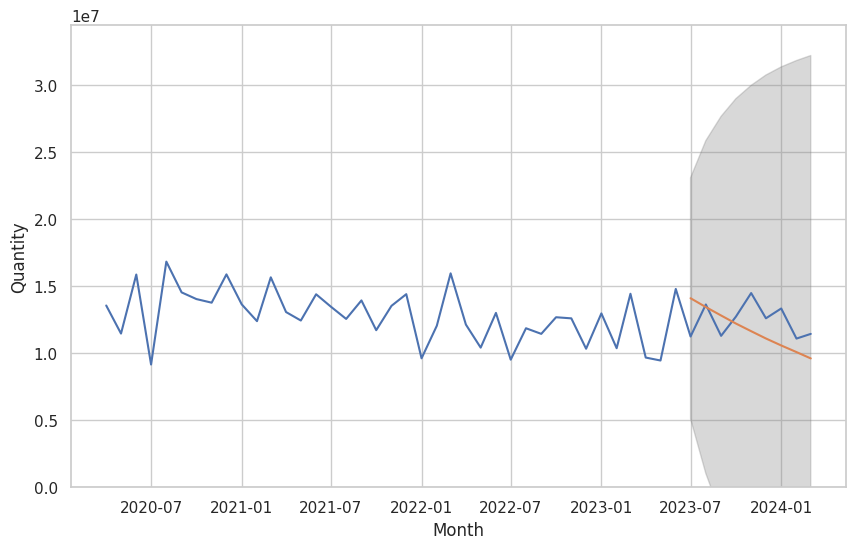

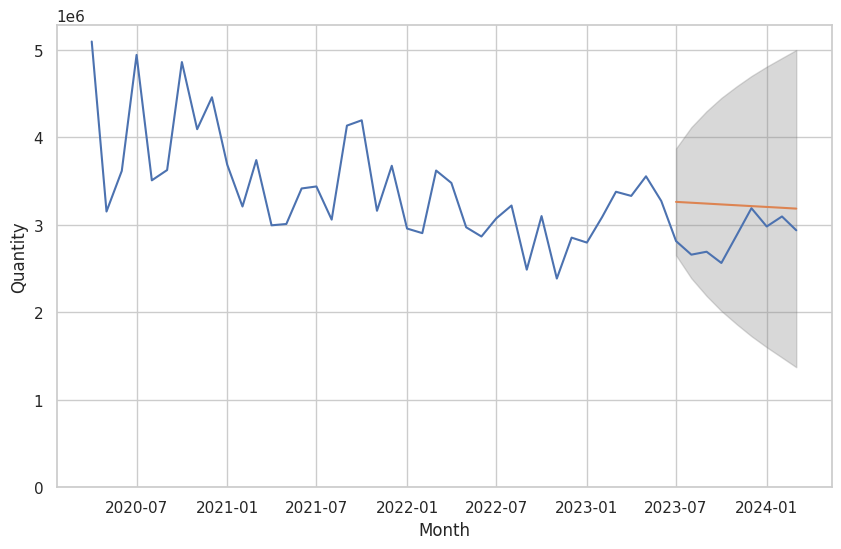

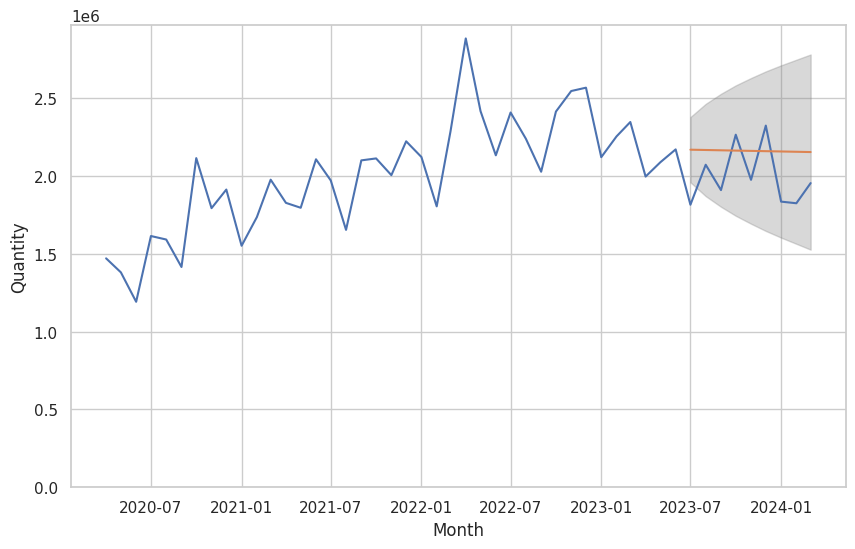

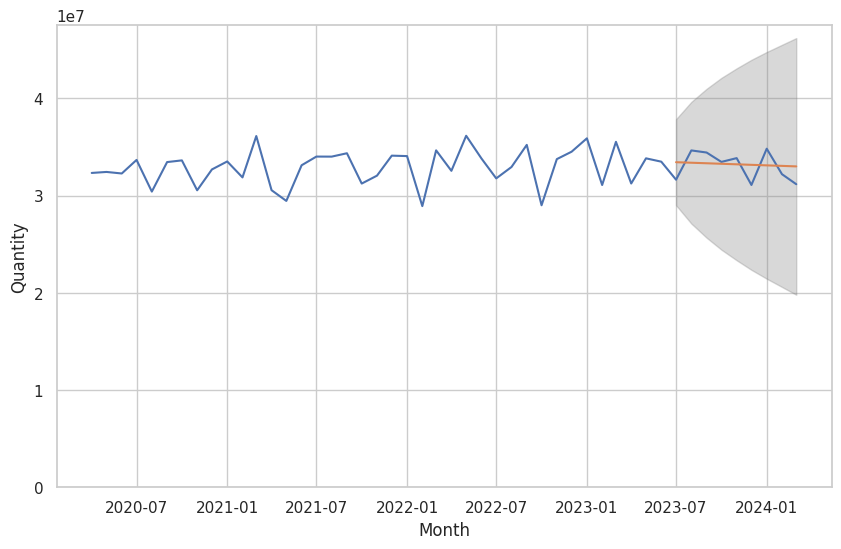

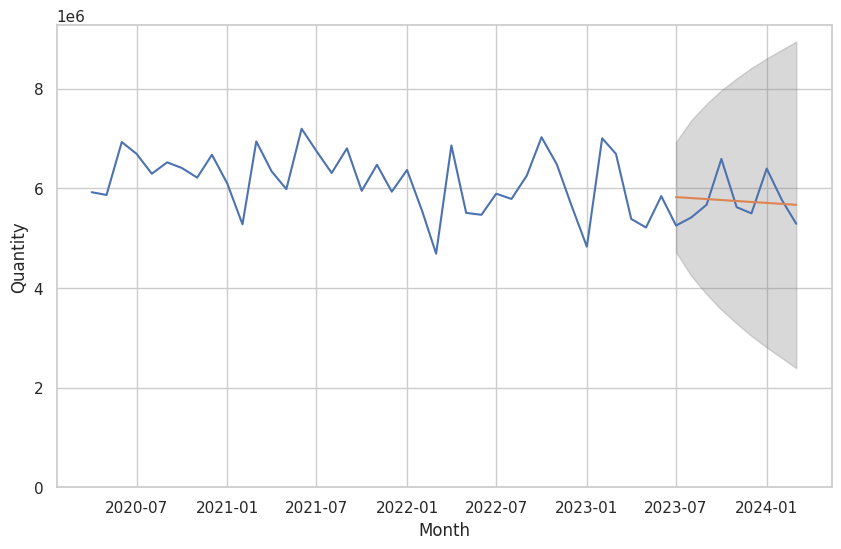

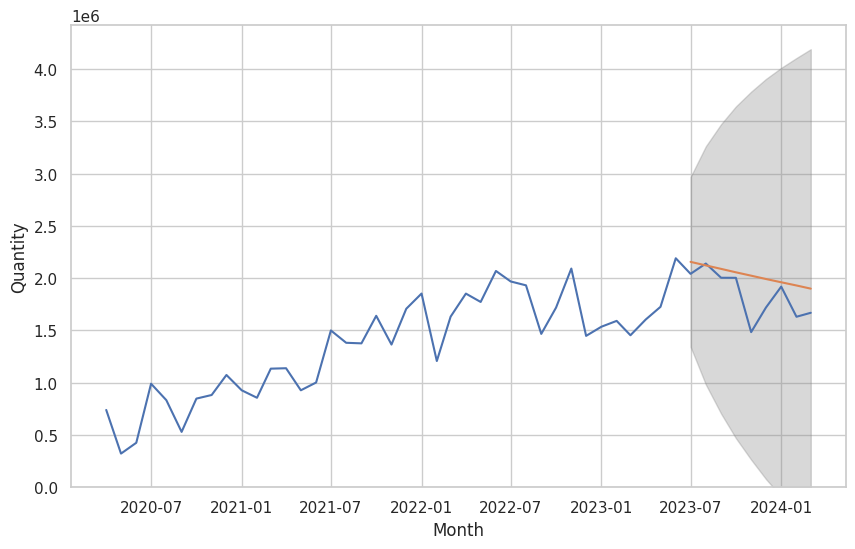

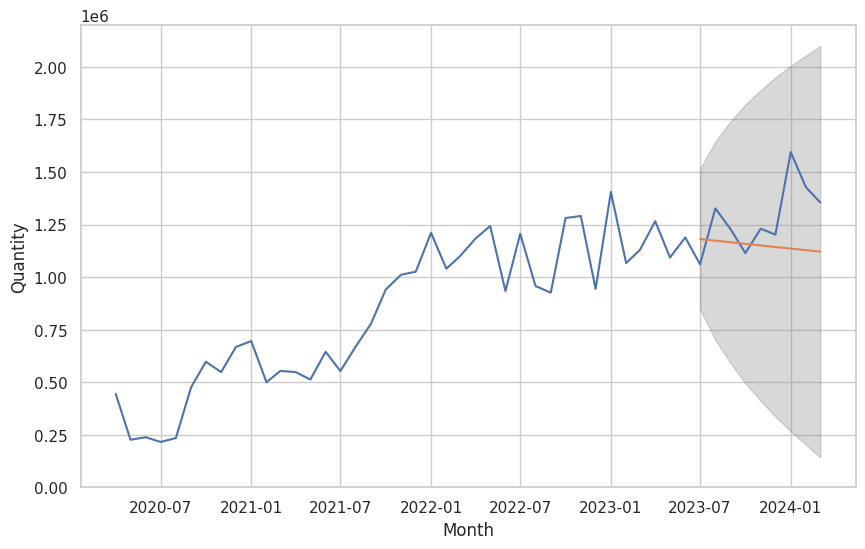

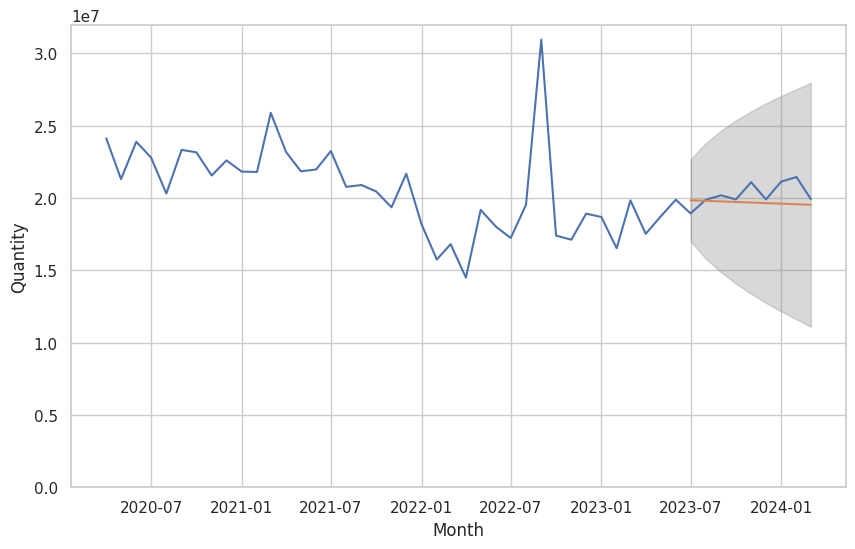

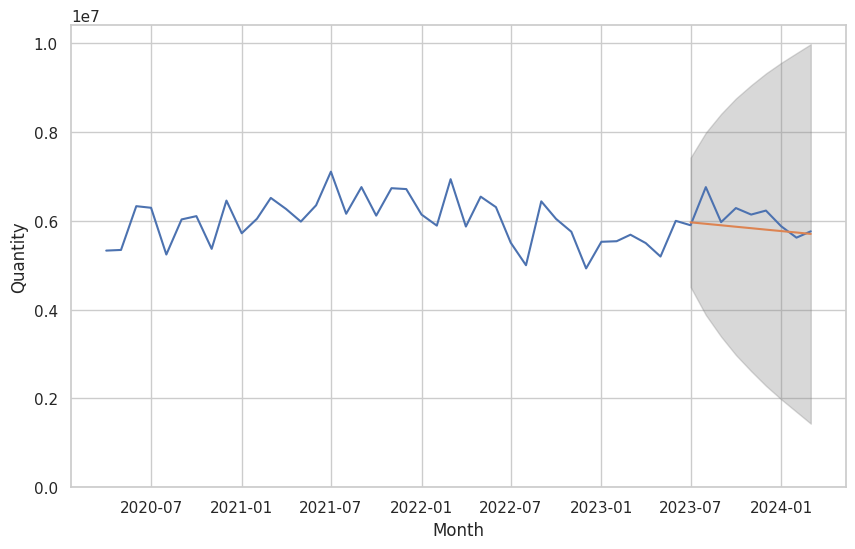

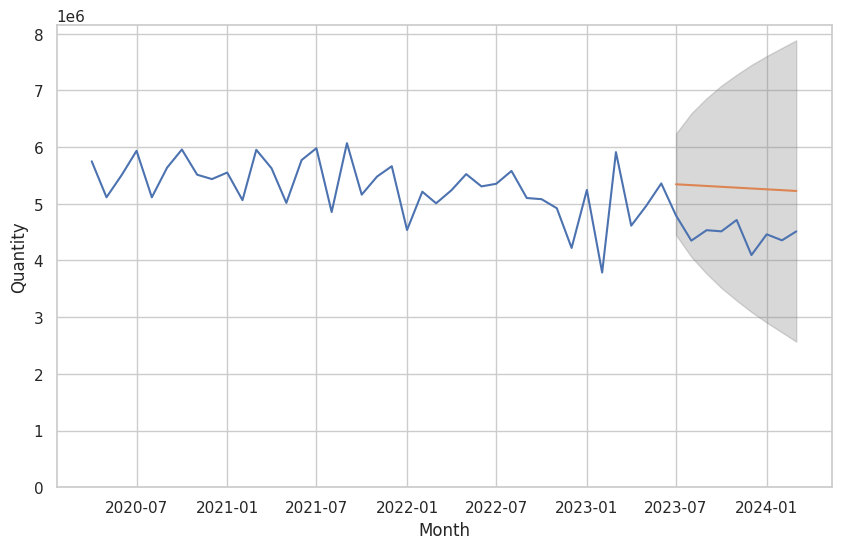

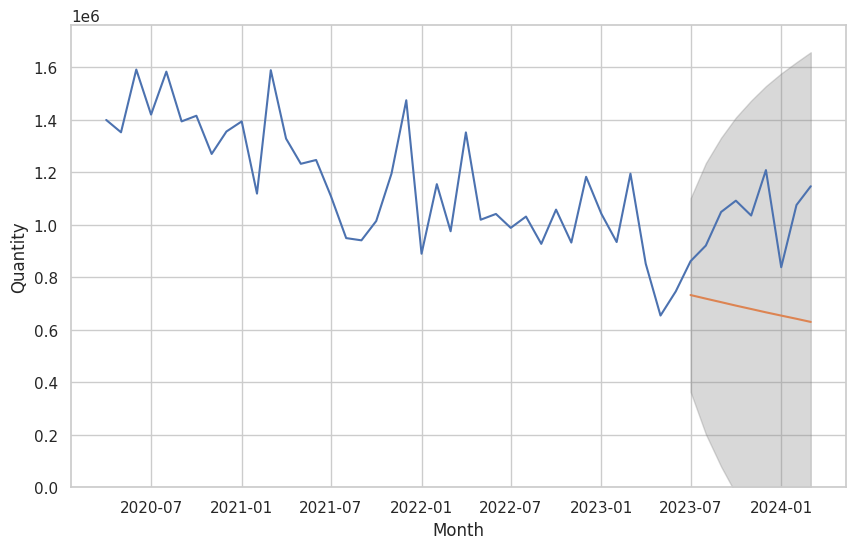

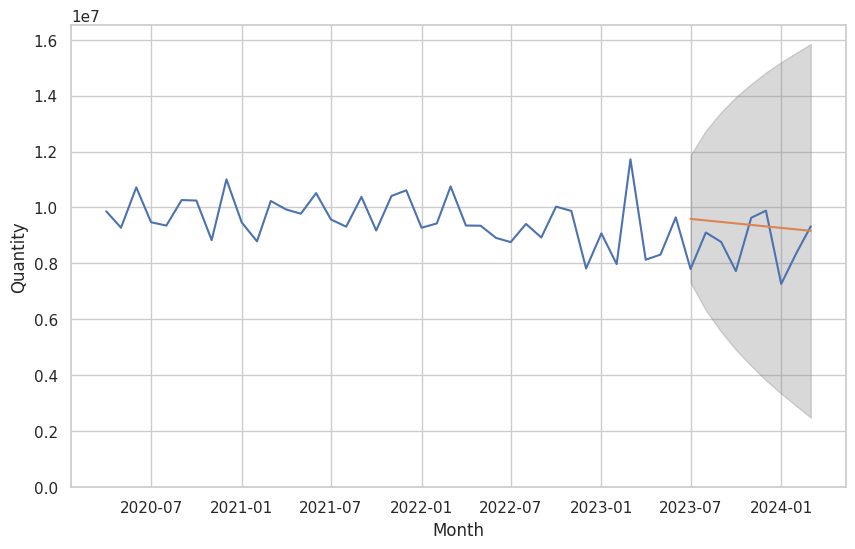

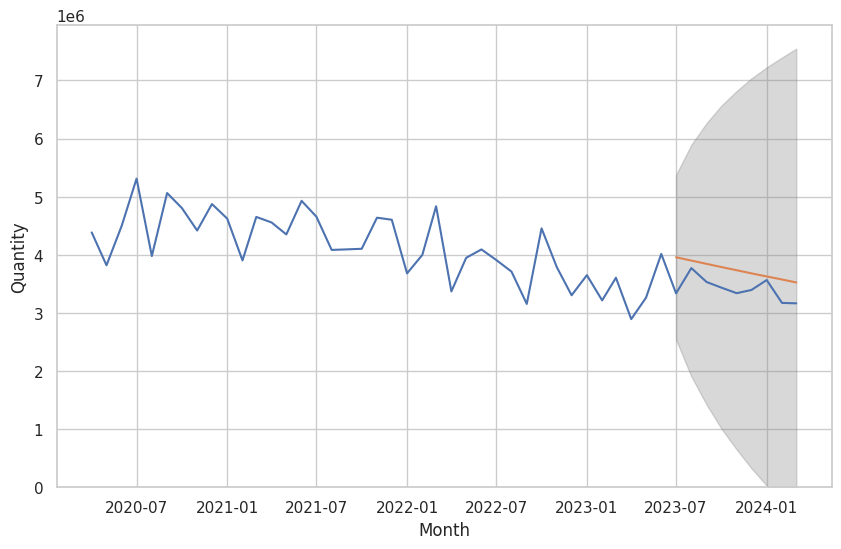

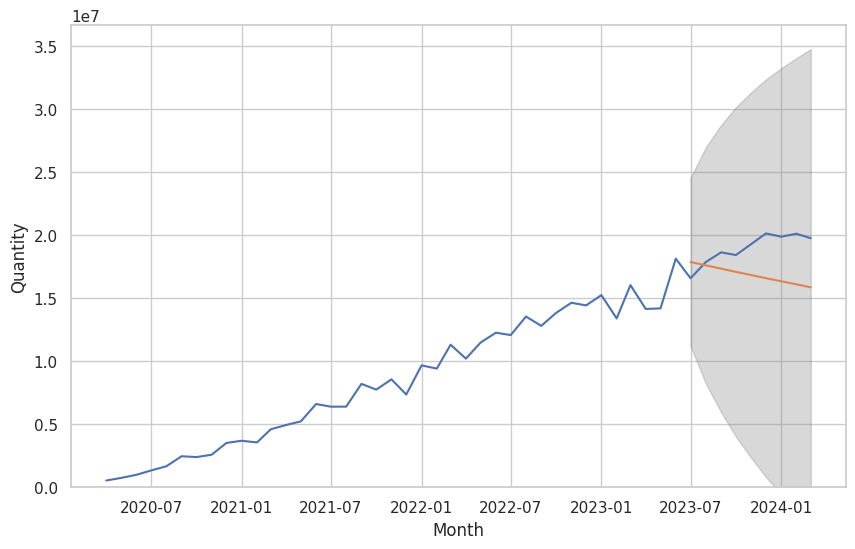

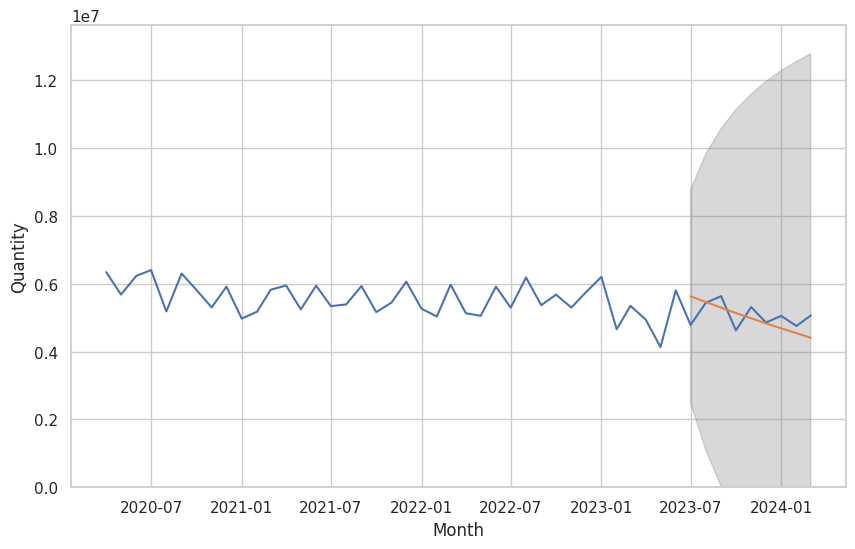

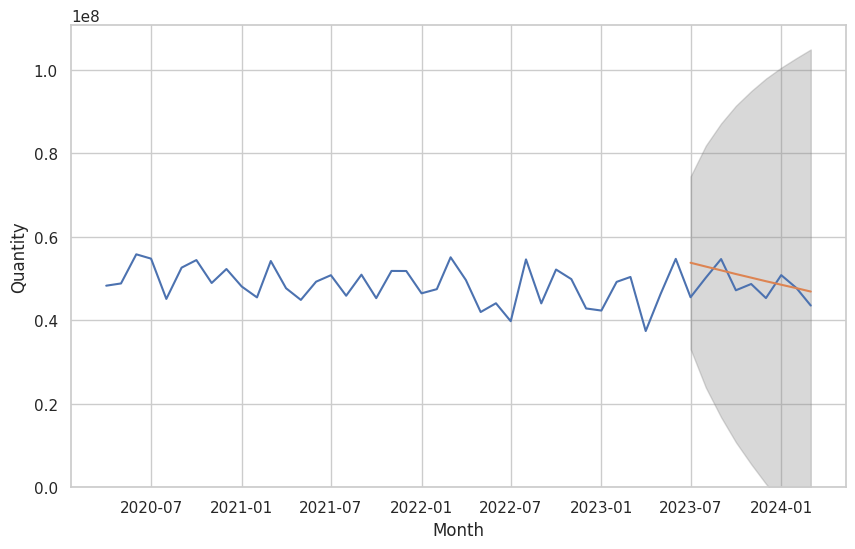

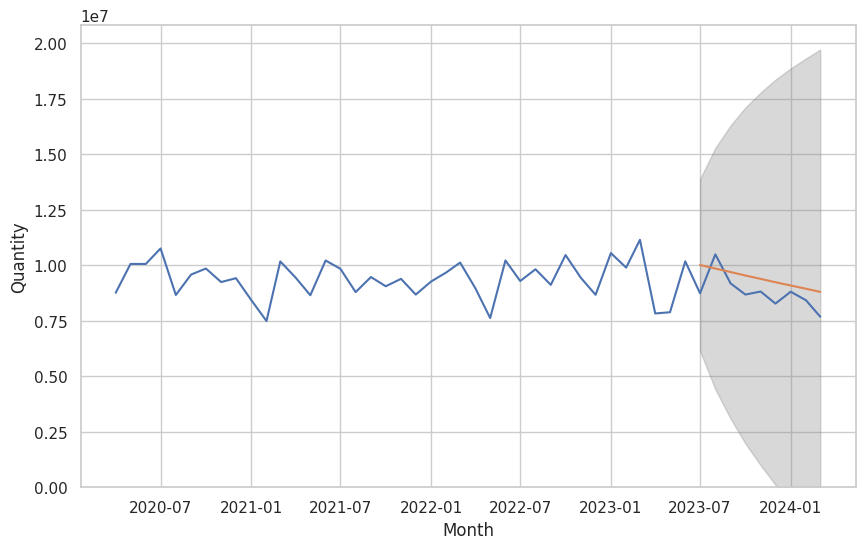

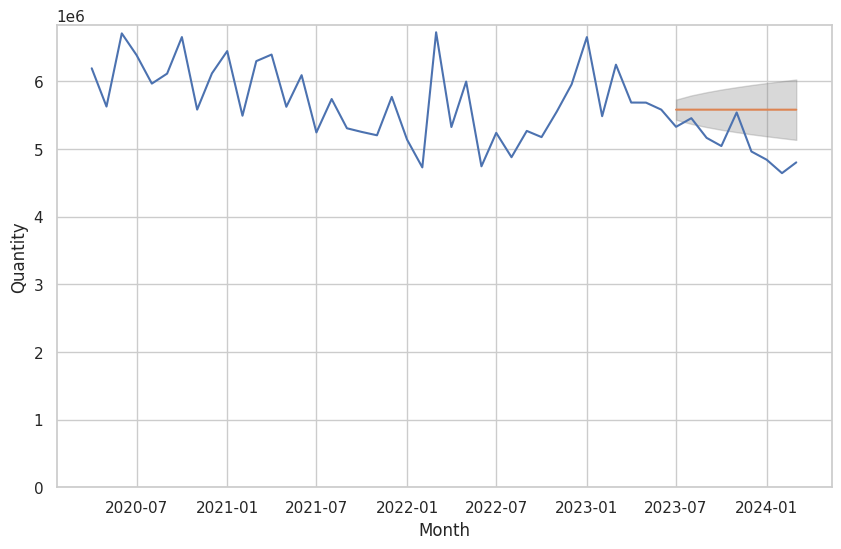

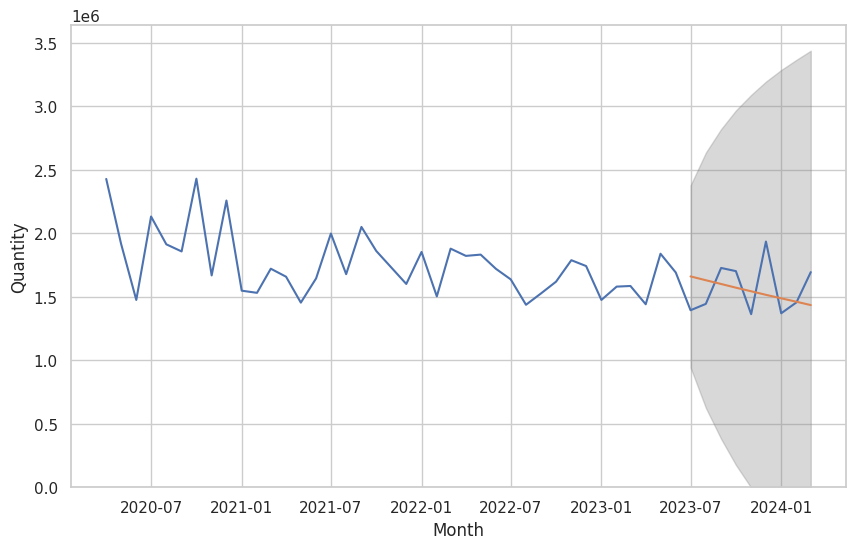

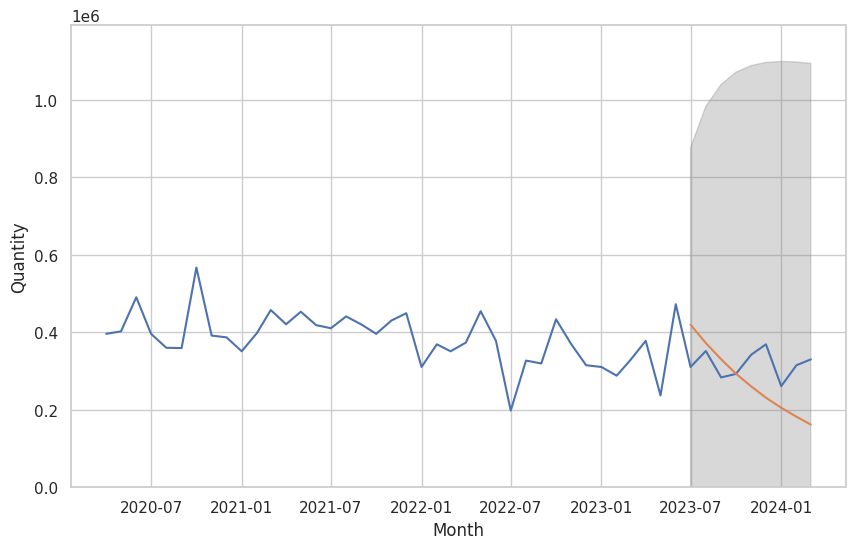

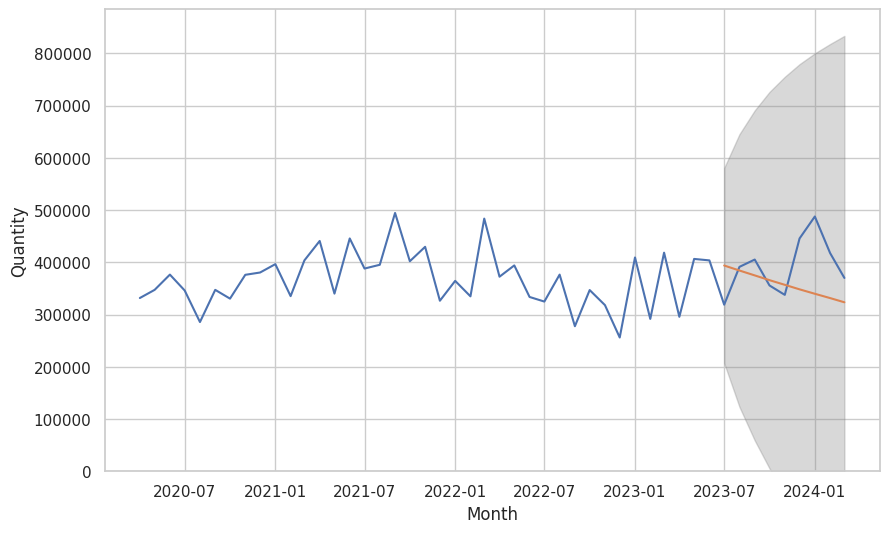

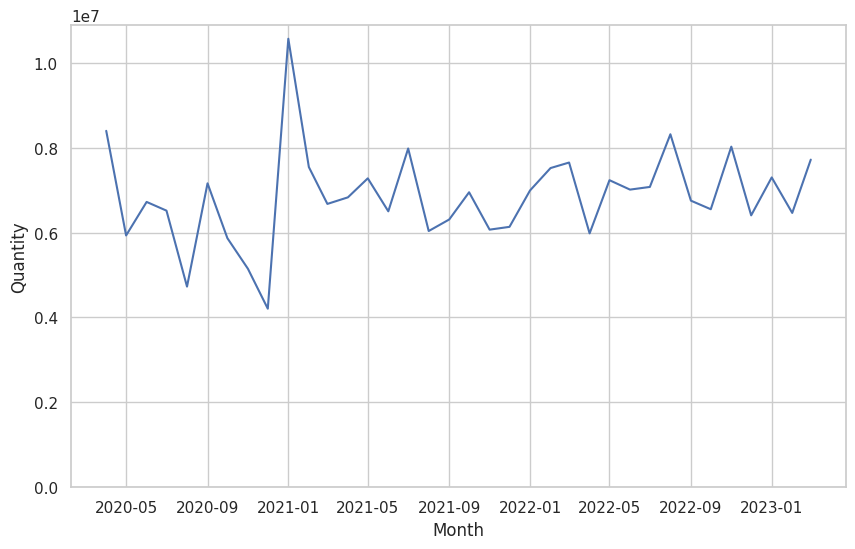

KeyboardInterrupt: 

In [235]:
#######TESTING TO DRAW QUANTITY ARIMA CHARTS############
# Limit to the first 20 unique bnf_codes
unique_bnf_codes = full_forecast_rx_df['bnf_code'].unique()
first_20_bnf_codes = unique_bnf_codes[:50]

for code in first_20_bnf_codes:
    # Filter the DataFrame for the current bnf_code
    filtered_df = full_forecast_rx_df[full_forecast_rx_df['bnf_code'] == code]
    
    # Plot month vs items
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_df['month'], filtered_df['quantity'])
    #plt.plot(filtered_df['month'], filtered_df['AutoETS'])
    #plt.fill_between(filtered_df['month'], filtered_df['AutoETS-lo-95'], filtered_df['AutoETS-hi-95'], color='gray', alpha=0.3, label='95% CI')
    plt.plot(filtered_df['month'], filtered_df['AutoARIMA'])
    plt.fill_between(filtered_df['month'], filtered_df['AutoARIMA-lo-95'], filtered_df['AutoARIMA-hi-95'], color='gray', alpha=0.3, label='95% CI')
    
    # Set the title to the bnf_name
    #plt.title(bnf_name)
    plt.ylim(bottom=0)
    
    # Label the axes
    plt.xlabel('Month')
    plt.ylabel('Quantity')
    
    # Show the plot
    plt.show()

In [226]:
#filter full_price df to reflect data available at time of forecasting - assume 2 months ahead of prescribing data
filtered_full_price_df = full_price_df[
    (full_price_df['month'] <= latest_pricing_data) &
    (full_price_df['bnf_code'].isin(top_bnf_codes))
]

# add latest available data through to each month to end of forecast
final_price_df = fill_missing_dates(filtered_full_price_df, end_forecast) 

In [227]:
filtered_full_price_df.head(10)

,month,bnf_code,dt_category,price_per_unit,pc_price_per_unit
58,2020-04-01,0402010U0AAAEAE,1,19.211733,NaN
59,2020-05-01,0402010U0AAAEAE,1,20.855736,NaN
60,2020-06-01,0402010U0AAAEAE,1,22.494187,NaN
61,2020-07-01,0402010U0AAAEAE,1,22.491765,NaN
62,2020-08-01,0402010U0AAAEAE,1,22.513557,NaN
63,2020-09-01,0402010U0AAAEAE,1,22.484501,NaN
64,2020-10-01,0402010U0AAAEAE,1,22.477237,NaN
65,2020-11-01,0402010U0AAAEAE,1,27.044015,NaN
66,2020-12-01,0402010U0AAAEAE,1,31.551800,NaN
67,2021-01-01,0402010U0AAAEAE,1,31.578941,NaN


In [228]:
costed_forecast_rx_df = pd.merge(full_forecast_rx_df, final_price_df, left_on = ['ds', 'unique_id'], right_on=['month', 'bnf_code'], how='outer', indicator=True) # merge to get prices
left_only_count = costed_forecast_rx_df['_merge'].value_counts()['left_only'] # check for whethere there are any drugs without prices
right_only_count = costed_forecast_rx_df['_merge'].value_counts()['right_only']
print(left_only_count)
print(right_only_count)

179846
163983


In [229]:
costed_forecast_rx_df.head()

,month_x,bnf_name,bnf_code_x,quantity,items,actual_cost,unique_id,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95,month_y,bnf_code_y,dt_category,price_per_unit,pc_price_per_unit,_merge
0,2020-04-01,Sodium bicarbonate 420mg/5ml (1mol/ml) soln su...,0101012B0AAABAB,258270.0,391.0,95172.21791,NaN,NaT,NaN,NaN,NaN,NaT,NaN,<NA>,NaN,NaN,left_only
1,2020-04-01,Jevity Promote liquid,0914011D0BBAAAA,15505000.0,550.0,175559.12950,NaN,NaT,NaN,NaN,NaN,NaT,NaN,<NA>,NaN,NaN,left_only
2,2020-04-01,Nutrison Protein Plus liquid,0914011E0BBAAAA,4113500.0,153.0,44359.84244,NaN,NaT,NaN,NaN,NaN,NaT,NaN,<NA>,NaN,NaN,left_only
3,2020-04-01,Osmolite Plus liquid,0914011E0BCAAAB,5652000.0,189.0,56791.80019,NaN,NaT,NaN,NaN,NaN,NaT,NaN,<NA>,NaN,NaN,left_only
4,2020-04-01,Fresubin 1200 Complete liquid,0914011F0BBABAD,2047000.0,80.0,29228.82033,NaN,NaT,NaN,NaN,NaN,NaT,NaN,<NA>,NaN,NaN,left_only


In [230]:
########ADD CODE TO DEAL WITH DISCOUNTS HERE##########

costed_forecast_rx_df['predicted_cost'] = costed_forecast_rx_df['AutoARIMA'] * (costed_forecast_rx_df['pc_price_per_unit'].fillna(.9367*costed_forecast_rx_df['price_per_unit']))/100
costed_forecast_rx_df['predicted_cost-lo-95'] = costed_forecast_rx_df['AutoARIMA-lo-95'] * (costed_forecast_rx_df['pc_price_per_unit'].fillna(.9367*costed_forecast_rx_df['price_per_unit']))/100
costed_forecast_rx_df['predicted_cost-hi-95'] = costed_forecast_rx_df['AutoARIMA-hi-95'] * (costed_forecast_rx_df['pc_price_per_unit'].fillna(.9367*costed_forecast_rx_df['price_per_unit']))/100

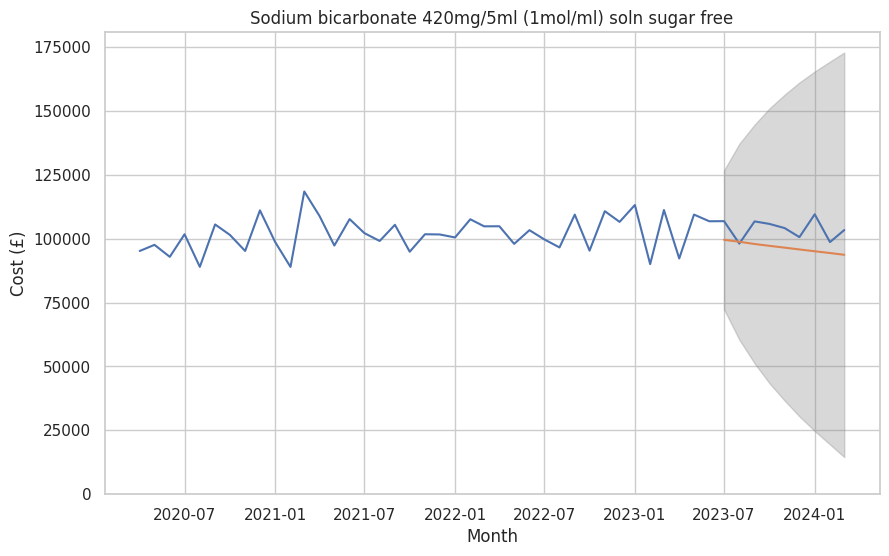

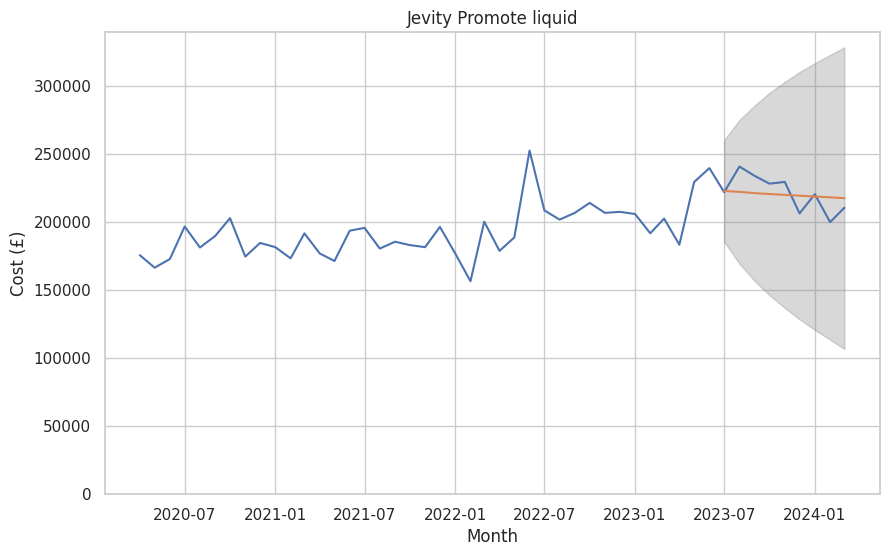

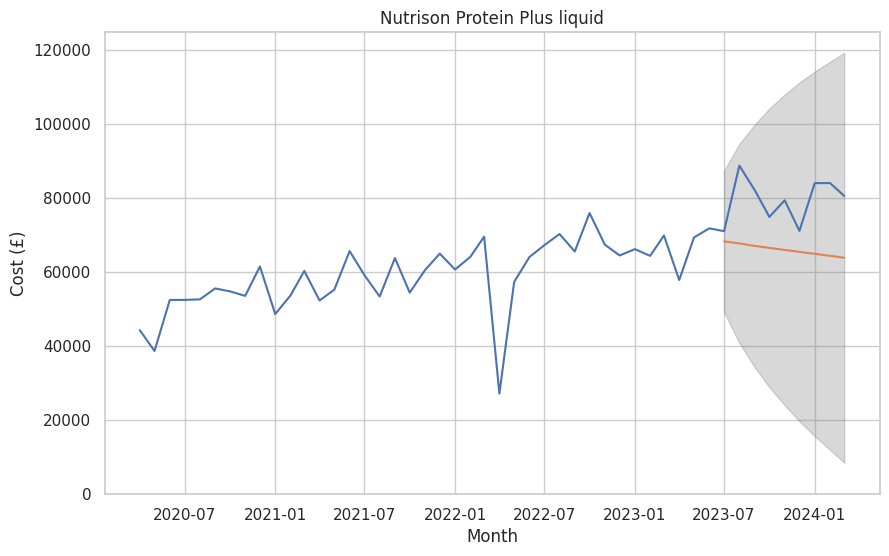

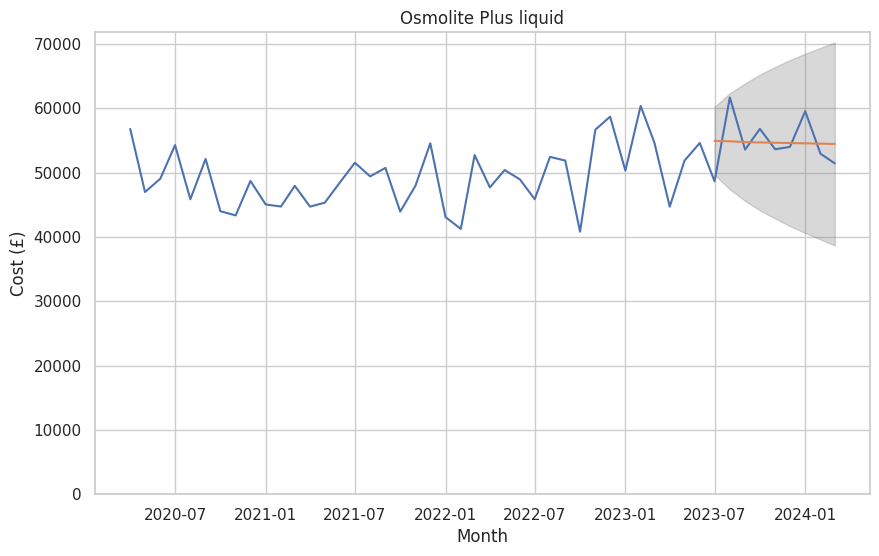

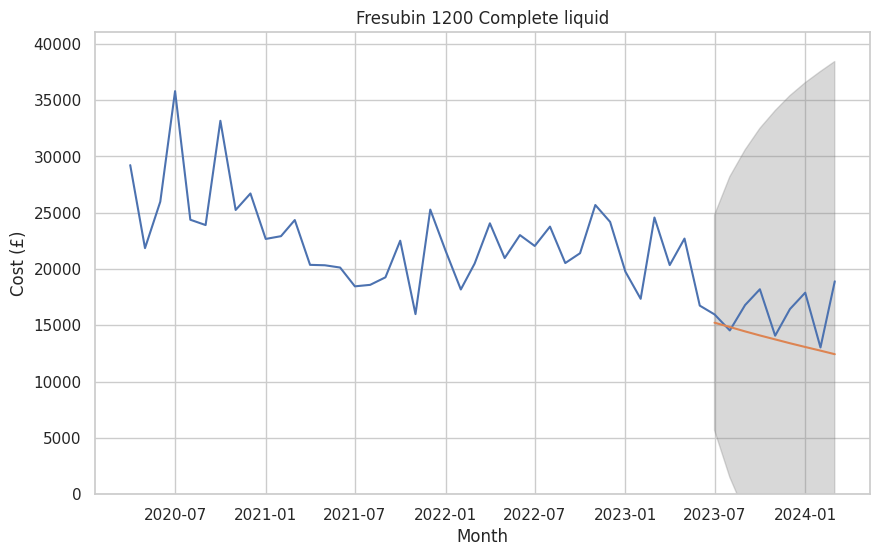

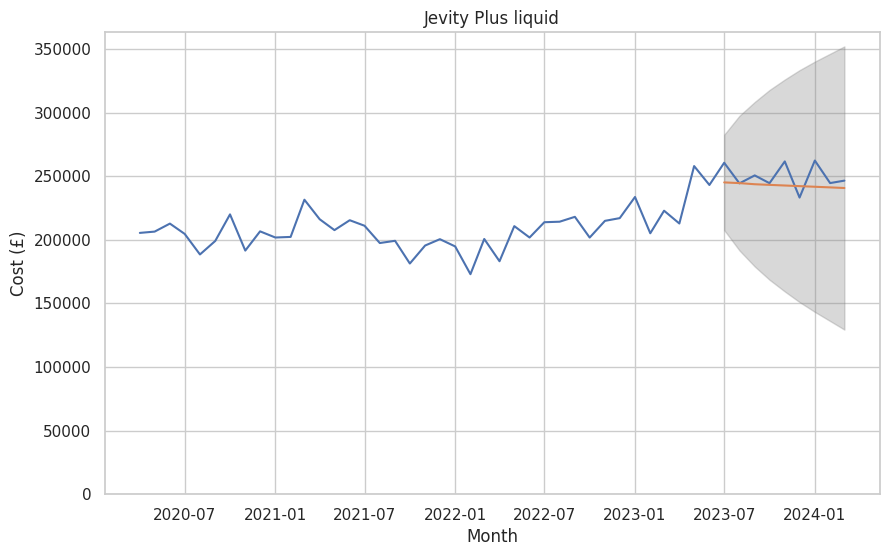

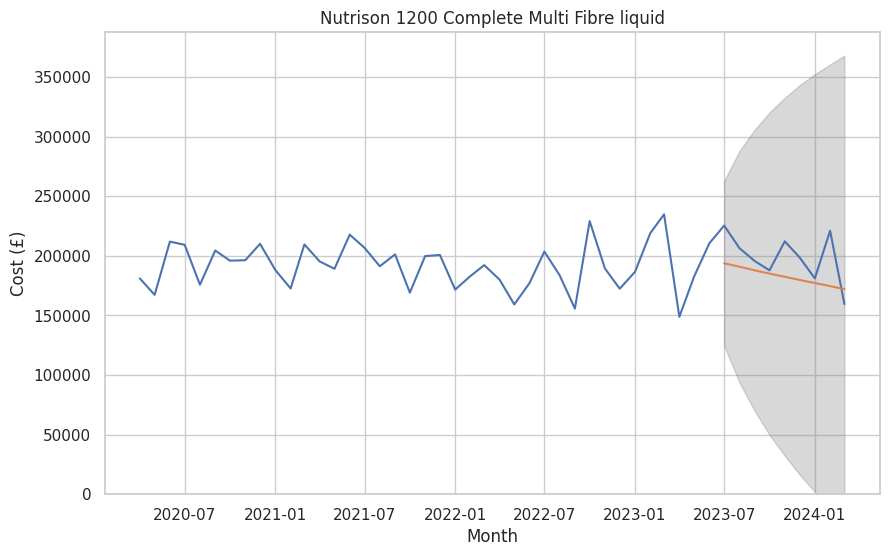

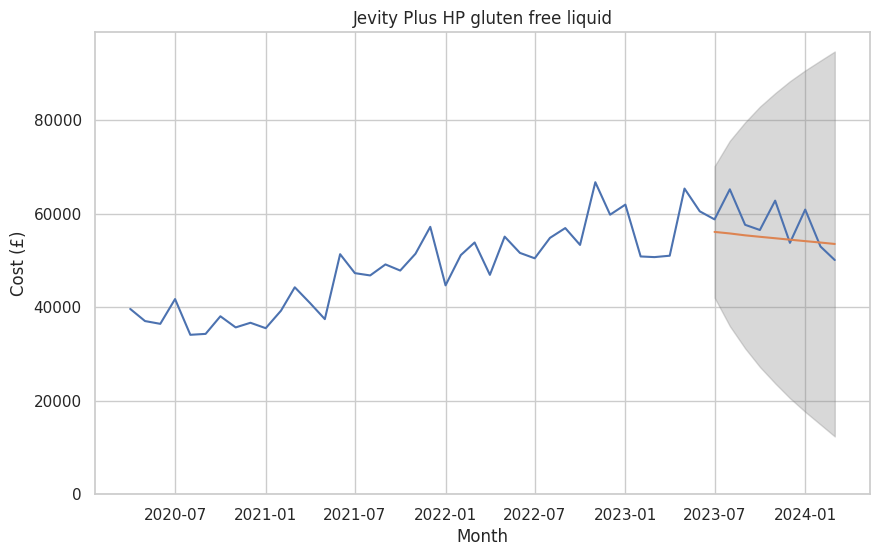

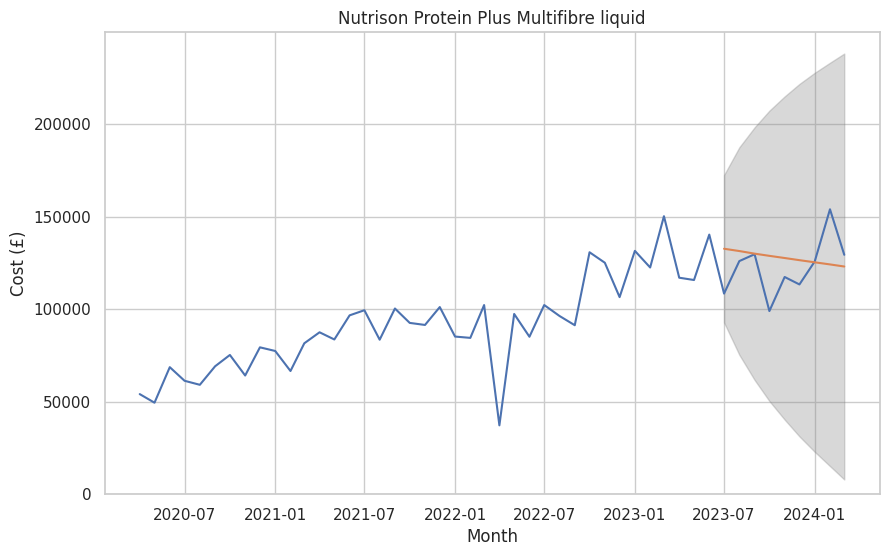

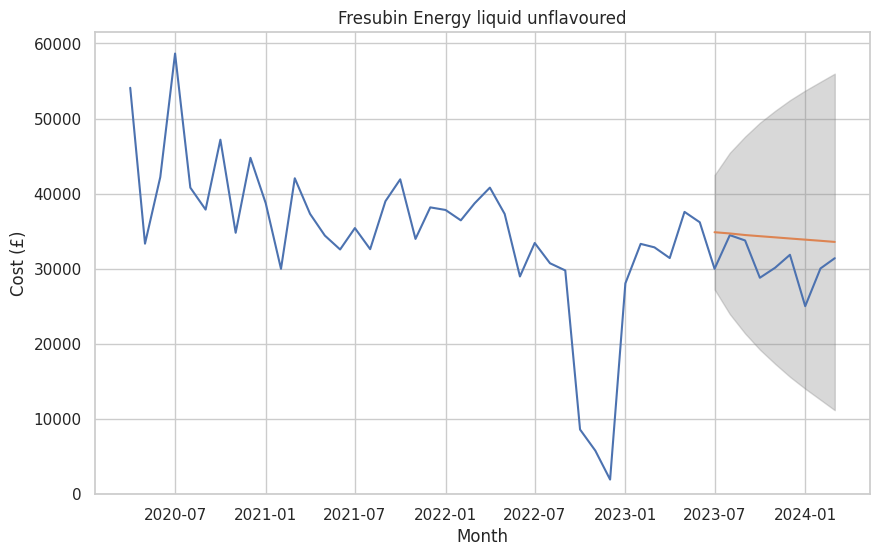

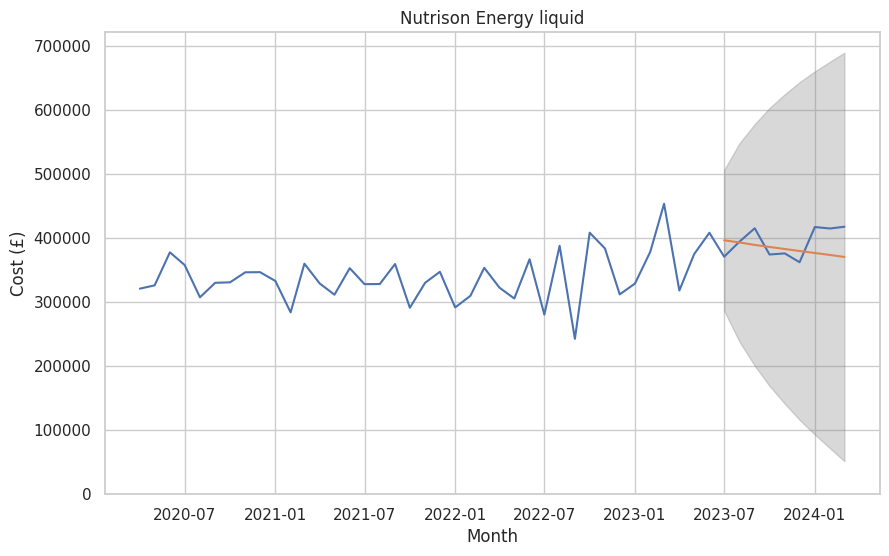

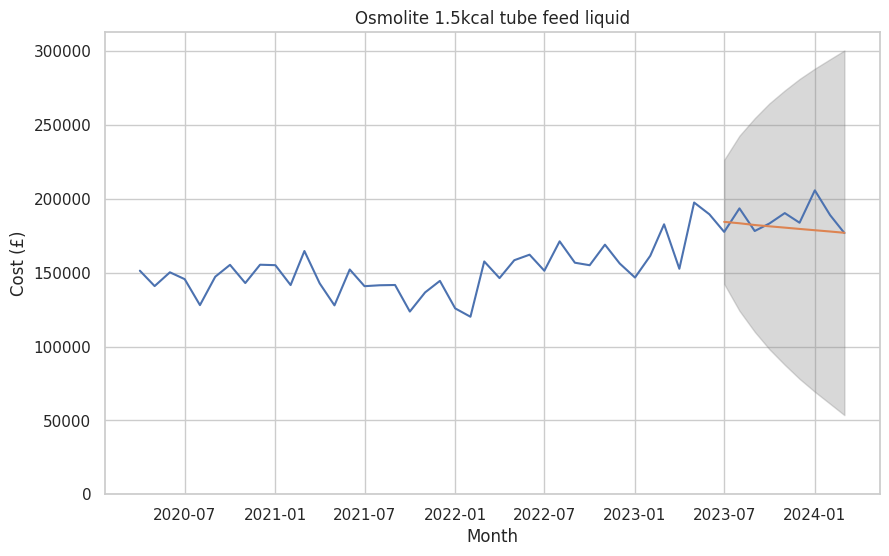

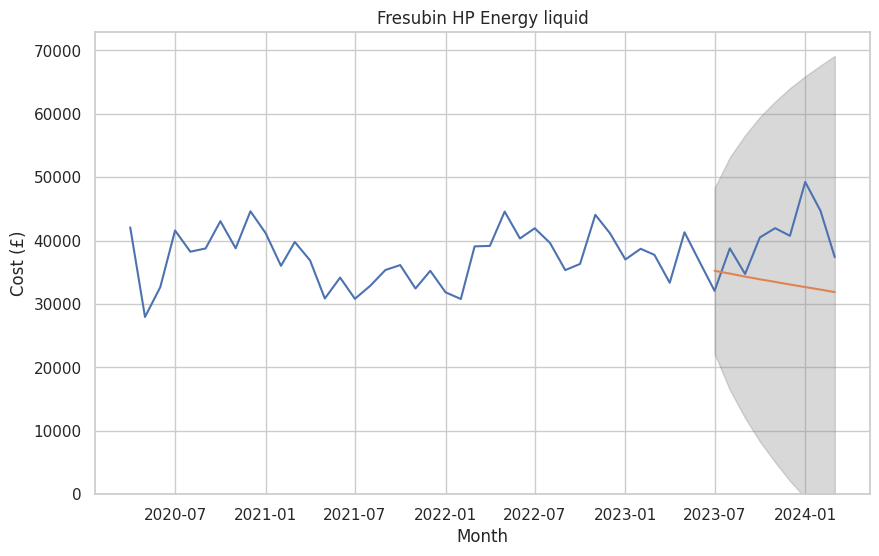

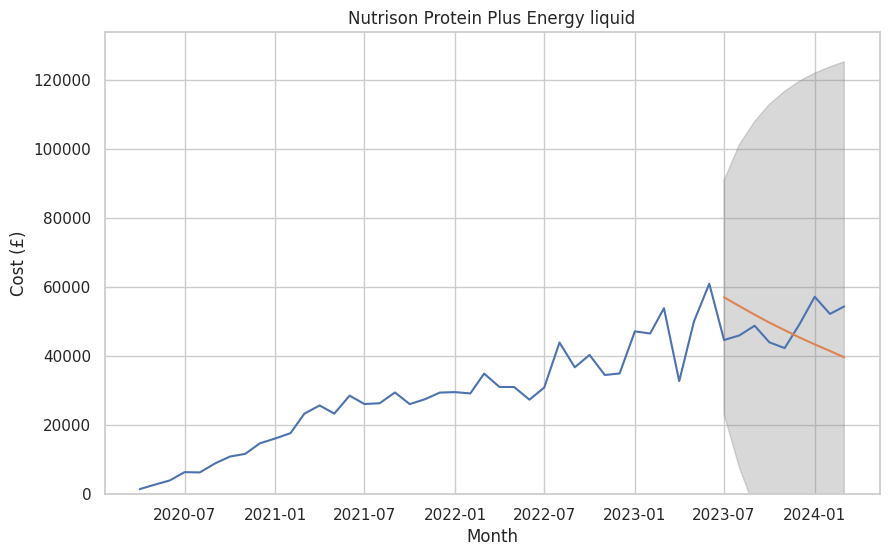

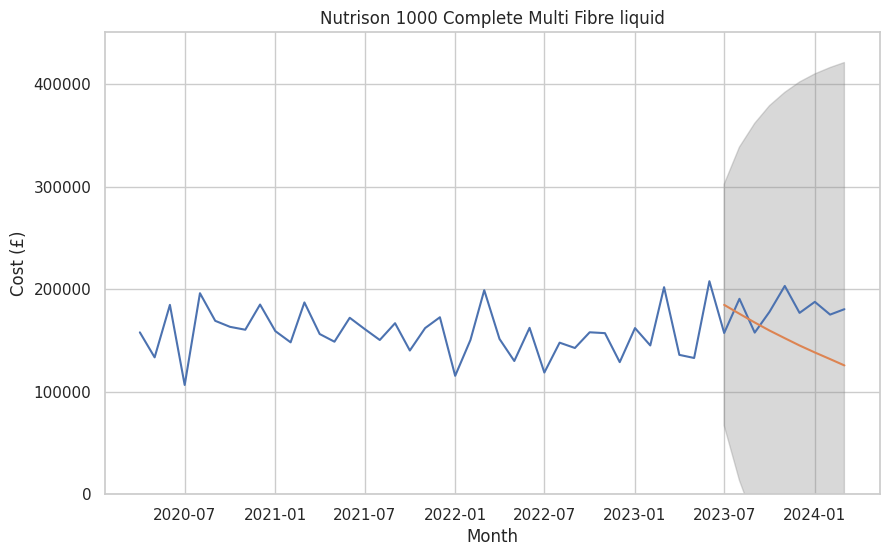

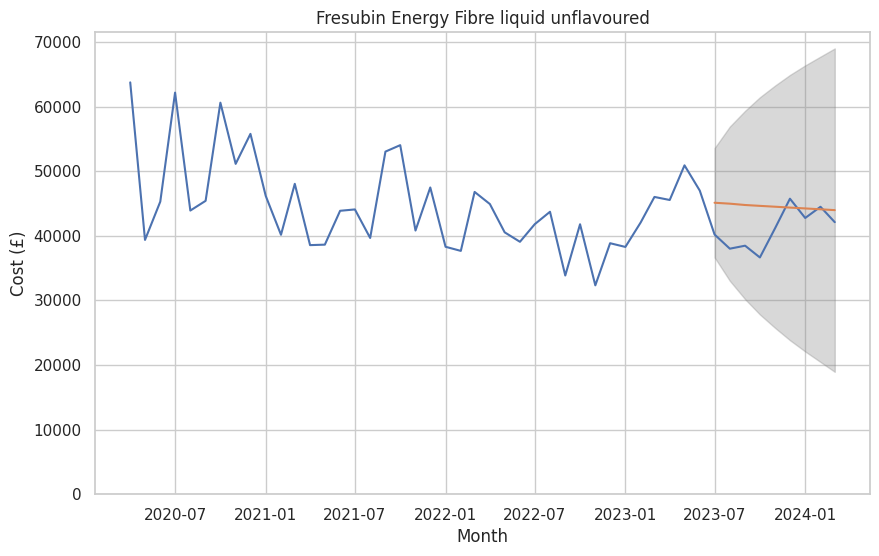

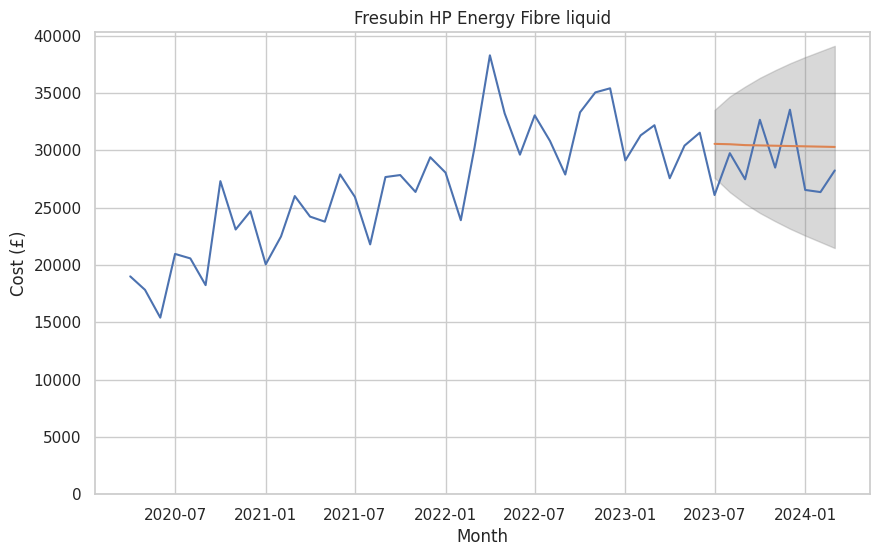

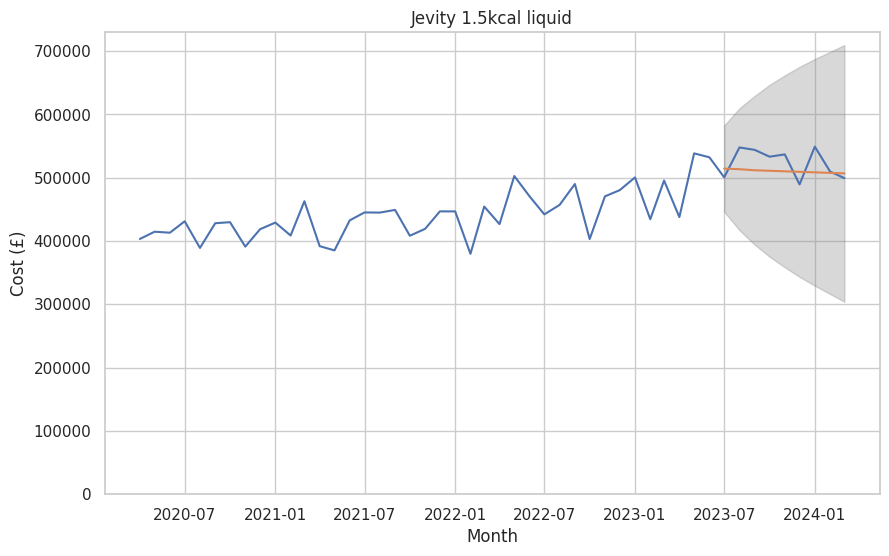

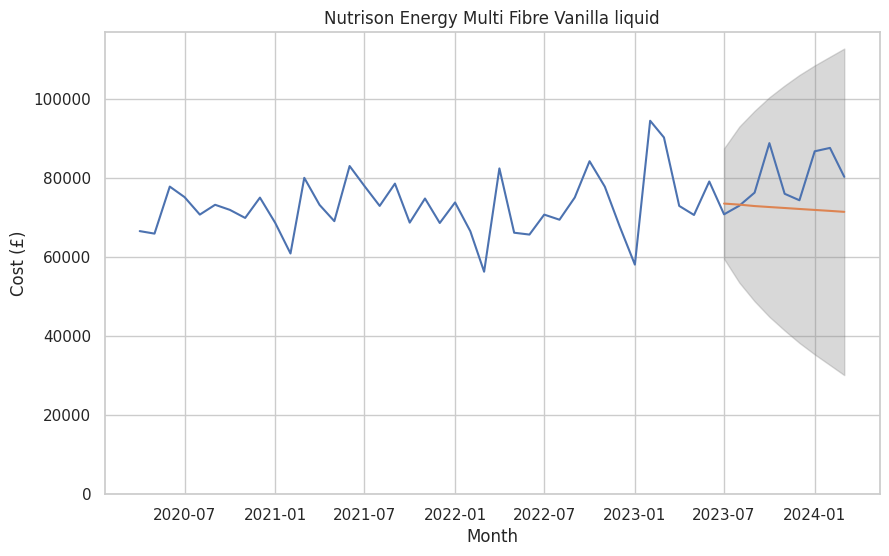

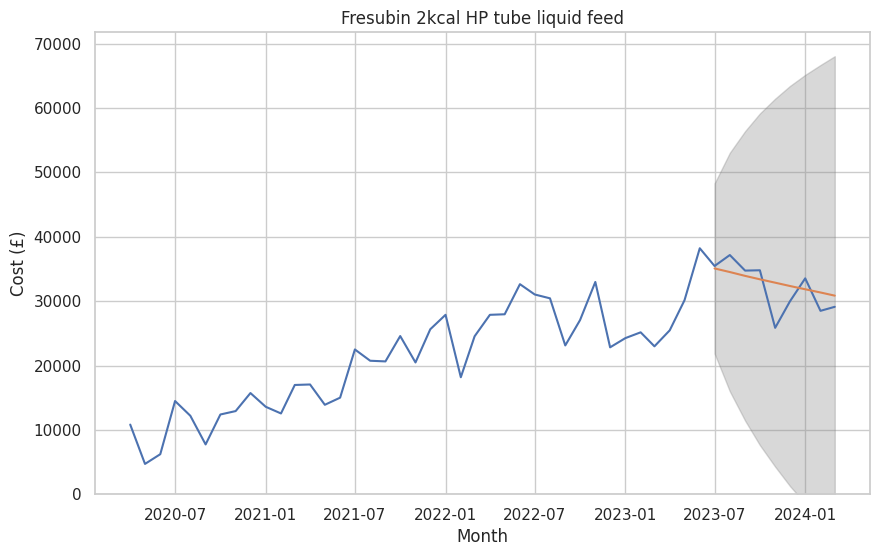

In [231]:
#######TESTING TO DRAW QUANTITY ARIMA CHARTS############
unique_bnf_codes =  costed_forecast_rx_df['bnf_code_x'].unique()
first_20_bnf_codes = unique_bnf_codes[:20]

for code in first_20_bnf_codes:
    # Filter the DataFrame for the current bnf_code
    filtered_df = costed_forecast_rx_df[costed_forecast_rx_df['bnf_code_x'] == code]

    # Get the corresponding bnf_name (assuming it's the same for all rows with this bnf_code_x)
    bnf_name = filtered_df['bnf_name'].iloc[0]  # Using .iloc[0] to get the first instance of the bnf_name
   
    # Plot month vs items
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_df['month_x'], filtered_df['actual_cost'])
    plt.plot(filtered_df['month_x'], filtered_df['predicted_cost'])
    plt.fill_between(filtered_df['month_x'], filtered_df['predicted_cost-lo-95'], filtered_df['predicted_cost-hi-95'], color='gray', alpha=0.3, label='95% CI')
    
    # Set the title to the bnf_name
    plt.title(bnf_name)
    plt.ylim(bottom=0)
    
    # Label the axes
    plt.xlabel('Month')
    plt.ylabel('Cost (£)')
    
    # Show the plot
    plt.show()

In [232]:
# look at cumulative costs

grouped_df = costed_forecast_rx_df.groupby('month_x')[['actual_cost', 'predicted_cost', 'predicted_cost-lo-95', 'predicted_cost-hi-95']].sum().reset_index()
grouped_df.replace(0, np.nan, inplace=True)
grouped_df = grouped_df[
    (grouped_df['month_x'] >= '2023-04-01')]

#fill the NAs in the predicted costs with the actual costs, to allow us to plot it
grouped_df['predicted_cost'] = grouped_df['predicted_cost'].fillna(grouped_df['actual_cost'])
grouped_df['predicted_cost-lo-95'] = grouped_df['predicted_cost-lo-95'].fillna(grouped_df['actual_cost'])
grouped_df['predicted_cost-hi-95'] = grouped_df['predicted_cost-hi-95'].fillna(grouped_df['actual_cost'])

#make a cumulative sum version
cumsum_grouped_df = grouped_df.copy()
cumsum_grouped_df[['actual_cost', 'predicted_cost', 'predicted_cost-lo-95', 'predicted_cost-hi-95']] = cumsum_grouped_df[['actual_cost', 'predicted_cost', 'predicted_cost-lo-95', 'predicted_cost-hi-95']].cumsum()

In [233]:
cumsum_grouped_df.head()

,month_x,actual_cost,predicted_cost,predicted_cost-lo-95,predicted_cost-hi-95
36,2023-04-01,7.474108e+08,7.474108e+08,7.474108e+08,7.474108e+08
37,2023-05-01,1.556658e+09,1.556658e+09,1.556658e+09,1.556658e+09
38,2023-06-01,2.384739e+09,2.384739e+09,2.384739e+09,2.384739e+09
39,2023-07-01,3.182495e+09,3.221796e+09,3.088557e+09,3.355036e+09
40,2023-08-01,3.990530e+09,4.057052e+09,3.736293e+09,4.377811e+09


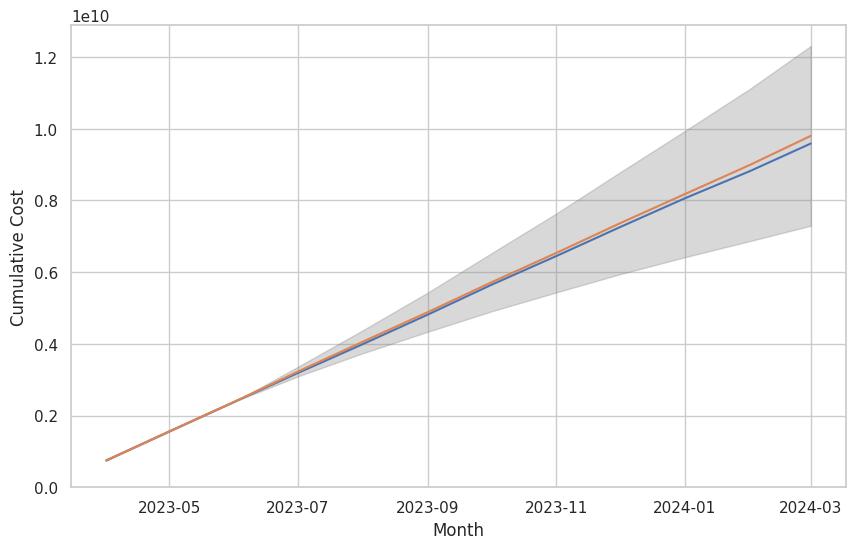

In [234]:
# plot the data

plt.figure(figsize=(10, 6))
plt.plot(cumsum_grouped_df['month_x'], cumsum_grouped_df['actual_cost'])
plt.plot(cumsum_grouped_df['month_x'], cumsum_grouped_df['predicted_cost'])
plt.fill_between(cumsum_grouped_df['month_x'], cumsum_grouped_df['predicted_cost-lo-95'], cumsum_grouped_df['predicted_cost-hi-95'], color='gray', alpha=0.3, label='95% CI')
    
    # Set the title to the bnf_name
    #plt.title(bnf_name)
plt.ylim(bottom=0)
    
    # Label the axes
plt.xlabel('Month')
plt.ylabel('Cumulative Cost')
    
    # Show the plot
plt.show()

## Part 4 - remaining x percent